In [88]:
from tracker import Tracker
from team_assigner import TeamAssigner
from utils import *
import cv2
from player_ball_assigner import PlayerBallAssigner
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    
    while True:
        ret,frame = cap.read()
        if not ret :
            break
        frames.append(frame)
    return frames
    
def save_video(in_video, out_path):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(out_path,fourcc,24,(in_video[0].shape[1],in_video[0].shape[0]))
    for frame in in_video:
        out.write(frame)
    out.release()
    

In [80]:
video_frames = read_video("data/08fd33_4.mp4")


tracker = Tracker("models/best.pt")

tracks = tracker.get_object_tracks(video_frames,read_from_stub=True,stub_path='stubs/tracks.pkl')

# interpolate ball positons
tracks['ball'] = tracker.interpolate_ball_positions(tracks['ball'])

ta =TeamAssigner()
ta.assign_team_color(video_frames[0],tracks['players'][0])

for frame_num, player_track in enumerate(tracks['players']):
    for player_id,track in player_track.items():
        team = ta.get_player_team(video_frames[frame_num],track['bbox'],player_id)
        tracks['players'][frame_num][player_id]['team'] = team
        tracks['players'][frame_num][player_id]['team_color'] = ta.team_colors[team]
team_ball_control =[]
        
pa =PlayerBallAssigner()
for frame_num, player_track in enumerate(tracks['players']):
    ball_bbox =tracks['ball'][frame_num][1]['bbox']
    ap = pa.assign_ball_to_player(player_track,ball_bbox)
    if ap != -1:
        tracks['players'][frame_num][ap]['has_ball'] = True
        team_ball_control.append(tracks['players'][frame_num][ap]['team'])
    else:
        team_ball_control[team_ball_control[-1]]
team_ball_control= np.array(team_ball_control)
  
   

output_video = tracker.draw_annotations(video_frames,tracks,team_ball_control)
save_video(output_video,'output_videos/output_video3.avi')


In [87]:
tracks['ball']

[{1: {'bbox': [1186.494873046875,
    849.4874877929688,
    1202.1370849609375,
    867.5054321289062]}},
 {1: {'bbox': [1186.494873046875,
    849.4874267578125,
    1202.1405029296875,
    867.6011352539062]}},
 {1: {'bbox': [1192.878662109375,
    853.6196594238281,
    1209.0076904296875,
    872.0965576171875]}},
 {1: {'bbox': [1199.262451171875,
    857.7518920898438,
    1215.8748779296875,
    876.5919799804688]}},
 {1: {'bbox': [1205.042724609375,
    862.1268310546875,
    1219.981201171875,
    881.6019287109375]}},
 {1: {'bbox': [1210.1234130859375,
    867.3382161458334,
    1225.61767578125,
    886.5307820638021]}},
 {1: {'bbox': [1215.2041015625,
    872.5496012369791,
    1231.254150390625,
    891.4596354166666]}},
 {1: {'bbox': [1220.2847900390625,
    877.760986328125,
    1236.890625,
    896.3884887695312]}},
 {1: {'bbox': [1224.197021484375,
    880.8387451171875,
    1241.0477294921875,
    900.3695068359375]}},
 {1: {'bbox': [1229.2342529296875,
    885.672912

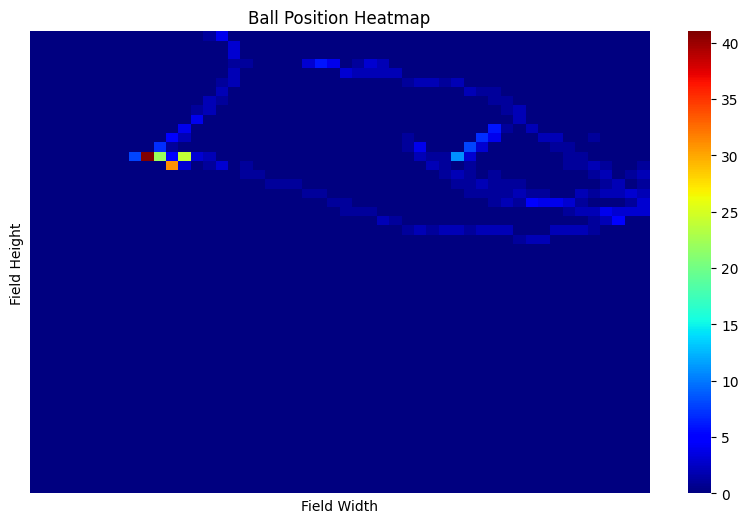

In [98]:
def generate_heatmap(ball_tracks, field_size=(1280, 720), bins=(50, 50)):
    # Extract the center coordinates of the ball from bbox data
    ball_positions = []
    for frame_data in ball_tracks:
        for _, data in frame_data.items():
            x1, y1, x2, y2 = data['bbox']
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            ball_positions.append((center_x, center_y))
    
    # Convert to numpy array
    ball_positions = np.array(ball_positions)
    
    # Create a 2D histogram
    heatmap, xedges, yedges = np.histogram2d(ball_positions[:, 0], ball_positions[:, 1], bins=bins, range=[[0, field_size[0]], [0, field_size[1]]])
    
    # Normalize heatmap for visualization
    heatmap = heatmap.T  # Transpose for correct orientation
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap, cmap='jet', cbar=True, xticklabels=False, yticklabels=False)
    plt.title("Ball Position Heatmap")
    plt.xlabel("Field Width")
    plt.ylabel("Field Height")
    plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates
    plt.show()
generate_heatmap(tracks['ball'])

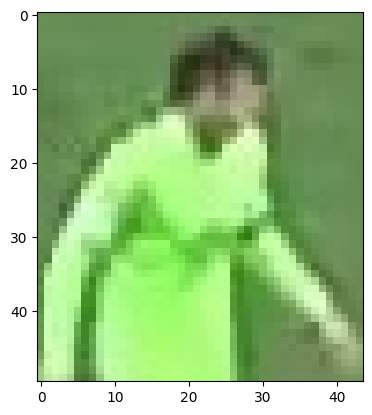

In [49]:
import matplotlib.pyplot as plt
image_path = './output_videos/player_crop.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.imshow(image)
half_image = image[0:int(image.shape[0]/2),:]
plt.imshow(half_image)

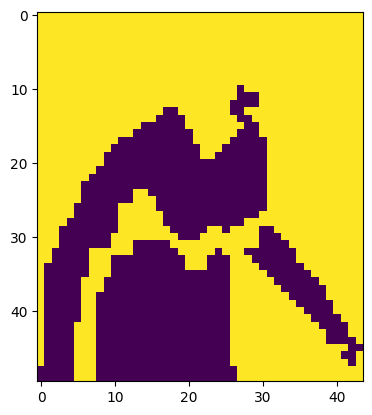

In [50]:
from sklearn.cluster import KMeans

# reshape image into 2d
image2d = half_image.reshape(-1,3)

# perform kmeans with two clusters
km = KMeans(n_clusters=2,random_state=0).fit(image2d)

labels = km.labels_

# reshape into original
c_image = labels.reshape(half_image.shape[0],half_image.shape[1])

plt.imshow(c_image)

In [51]:
corner_cluster = [c_image[0,0],c_image[0,-1],c_image[-1,0],c_image[-1,-1]]
non_player_c = max(set(corner_cluster),key=corner_cluster.count)
player_c = 1 - non_player_c
print(non_player_c,player_c)

1 0


In [52]:
km.cluster_centers_[player_c]

array([     176.28,      242.78,      140.38])

In [61]:
tracks['players'][0][5]

{'bbox': [222.8678741455078,
  513.5582885742188,
  255.2273712158203,
  595.8931274414062],
 'team': 1,
 'team_color': array([     228.15,      228.59,      218.51])}

[{1: {'bbox': [1186.494873046875,
    849.4874877929688,
    1202.1370849609375,
    867.5054321289062]}},
 {1: {'bbox': [1186.494873046875,
    849.4874267578125,
    1202.1405029296875,
    867.6011352539062]}},
 {},
 {1: {'bbox': [1199.262451171875,
    857.7518920898438,
    1215.8748779296875,
    876.5919799804688]}},
 {1: {'bbox': [1205.042724609375,
    862.1268310546875,
    1219.981201171875,
    881.6019287109375]}},
 {},
 {},
 {1: {'bbox': [1220.2847900390625,
    877.760986328125,
    1236.890625,
    896.3884887695312]}},
 {1: {'bbox': [1224.197021484375,
    880.8387451171875,
    1241.0477294921875,
    900.3695068359375]}},
 {1: {'bbox': [1229.2342529296875,
    885.6729125976562,
    1244.8883056640625,
    904.0153198242188]}},
 {},
 {1: {'bbox': [1234.5540771484375,
    894.7677612304688,
    1251.739013671875,
    912.9124145507812]}},
 {1: {'bbox': [1235.1763916015625,
    897.984375,
    1255.2923583984375,
    914.2540283203125]}},
 {},
 {1: {'bbox': [1245.18835